#### Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

#### Data

In [4]:
bolt_food = pd.read_csv('data/app_store_data/bolt_food_data.csv')
glovo = pd.read_csv('data/app_store_data/glovo_data.csv')
grubhub = pd.read_csv('data/app_store_data/grubhub_data.csv')
uber_eats = pd.read_csv('data/app_store_data/uber_eats_data.csv')
wolt = pd.read_csv('data/app_store_data/wolt_data.csv')

app_store = pd.concat([bolt_food, glovo, grubhub, uber_eats, wolt])

bolt_food = pd.read_csv('data/google_play_data/bolt_food_data.csv')
glovo = pd.read_csv('data/google_play_data/glovo_data.csv')
grubhub = pd.read_csv('data/google_play_data/grubhub_data.csv')
uber_eats = pd.concat([pd.read_csv(f'data/google_play_data/uber_eats_data_part{i}.csv') for i in range(1, 8)])
wolt = pd.read_csv('data/google_play_data/wolt_data.csv')

google_play = pd.concat([bolt_food, glovo, grubhub, uber_eats, wolt])

del bolt_food
del glovo
del grubhub
del uber_eats
del wolt

app_store.rename(columns={'review': 'content', 'rating': 'score', 'date': 'at'}, inplace=True)

app_store['platform'] = 'App Store'
google_play['platform'] = 'Google Play'

df = pd.concat([app_store, google_play], axis=0)
df.rename(columns={'at': 'date', 'repliedAt': 'repliedDate'}, inplace=True)

del app_store
del google_play

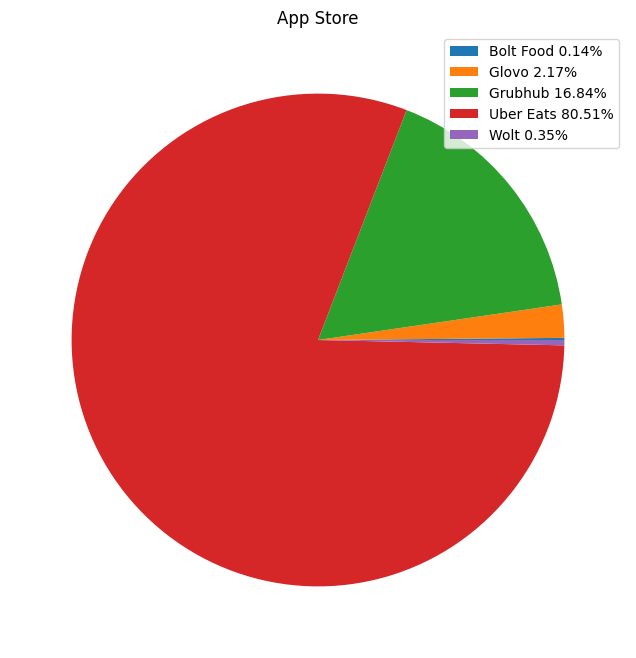

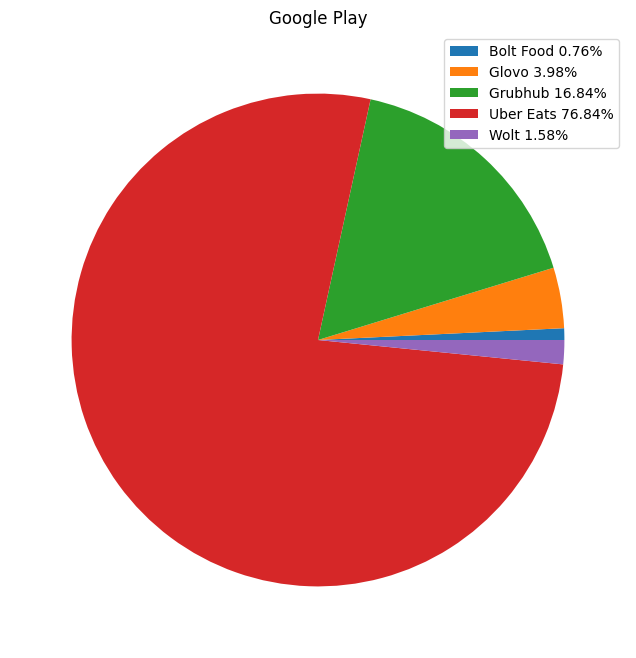

In [14]:
def calculate_Percentage(data_frame):
    list_for_legend_items = []
    for app in data_frame.app.unique():
        percentage = round((len(data_frame[data_frame.app == app]) /
                            len(data_frame) * 100), 2)
        list_for_legend_items.append(str(f"{app} {percentage}%"))

    return list_for_legend_items

def create_pie_plot(dataframe, size : list, title : str):
    plt.figure(figsize=(size[0], size[1]))
    plt.title(title)
    plt.pie(
        [len(dataframe[dataframe.app == app])
        for app in dataframe.app.unique()]
    )
    plt.legend(calculate_Percentage(dataframe))


app_store_df = df[(df.platform == "App Store")]
google_play_df = df[(df.platform == "Google Play")]
create_pie_plot(app_store_df, [8,8], "App Store")
create_pie_plot(google_play_df,[8,8], "Google Play")

In [24]:
df.head(3)

,score,content
0,5,"Being single and traveling a lot for work, all..."
1,4,App is well-designed and nice to use. Only com...
2,1,I’ve had this payment issue for over a month n...


# EDA

In [15]:
df = df[['score', 'content']]

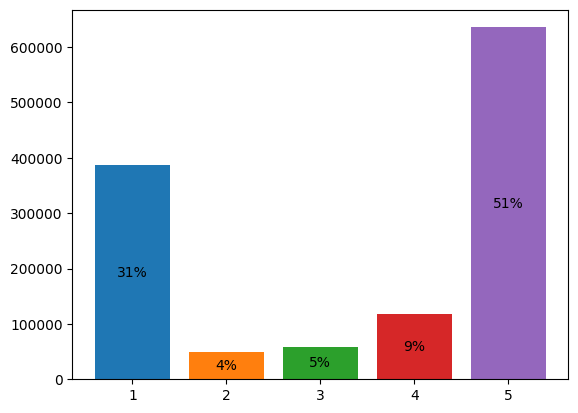

In [16]:
for i in range(1, 6):
    n = len(df[df.score == i])
    plt.bar(i-1, n)
    rate = round(n / len(df) * 100)
    plt.text(i-1, n//2, f"{rate}%", horizontalalignment='center', verticalalignment='center')
plt.xticks(np.arange(5), np.arange(1, 6))
plt.show()

# Data preprocessing

#### Nan values

In [8]:
df.isna().sum()

score        0
content    331
dtype: int64

In [5]:
df.dropna(inplace=True)
df.isna().sum()

score      0
content    0
dtype: int64

#### Duplicates

In [16]:
df.duplicated().sum()

299398

In [6]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

#### Remove non-english comments

In [7]:
uniqueCharacters = set()
for comment in df['content']:
    uniqueCharacters.update(set(list(comment)))

In [165]:
len(uniqueCharacters)

3997

Emojis

Source: <a href="https://gist.github.com/bfeldman89/fb25ddb63bdaa6de6ab7ac946acde96f">List of emojis</a>

In [8]:
emojis = pd.read_csv('data/characters/emojis.csv')
emojis = list(set(emojis.Emoji))
emojis[:10]

['💼', '↙', '⏰', '🇸🇷', '🍖', '🔴', '🇳🇵', '🇻🇪', '🇬🇶', '😩']

Latin Alphabet

In [9]:
latinAlphabet = list(map(chr, range(65, 91)))
latinAlphabet = latinAlphabet + [char.lower() for char in latinAlphabet]

Numbers

In [10]:
numbers = list(map(str, range(0, 10)))

Other Characters

In [11]:
specialSymbols = set("!@#$%^&*()-_=+`~[]{}\|;:'\",.<>/?") + [' ']

In [12]:
other = uniqueCharacters\
    .difference(latinAlphabet)\
    .difference(emojis)\
    .difference(specialSymbols)\
    .difference(numbers)

other = '|'.join(other)

df_new = df[~df.content.str.contains(other)]

In [17]:
len(df_new)

805681

#### Split to train and test data sets

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_new['content'], df_new['score'], test_size=0.1, random_state=42)

#### Vectorization

Source: <a href="https://towardsdatascience.com/basics-of-countvectorizer-e26677900f9c">Towards data science</a>

In [14]:
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
ENGLISH_STOP_WORDS = list(ENGLISH_STOP_WORDS)

vect = CountVectorizer(stop_words=ENGLISH_STOP_WORDS, max_features=10000).fit(X_train)

X_train_vectorized = vect.transform(X_train)
X_test_vectorized = vect.transform(X_test)

In [20]:
len(vect.get_feature_names_out())

10000

# Model

#### Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression

logReg = LogisticRegression()
logReg.fit(X_train_vectorized, y_train)

LogisticRegression()

In [25]:
y_pred = logReg.predict(X_test_vectorized)
y_pred

array([5, 5, 5, ..., 5, 1, 5], dtype=int64)

In [26]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.7535900904814506